In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../") # <-- Path to the DRL4AMM repo


from DRL4AMM.rewards.RewardFunctions import PnL, CJ_criterion

from DRL4AMM.tile_coding.tile_coding import *

In [2]:
from DRL4AMM.gym.MMAtTouchEnvironment import MMAtTouchEnvironment

In [3]:
terminal_time = 1.0
n_steps = 100
arrival_rate = 50.0
reward_function = CJ_criterion()
timestamps = np.linspace(0, terminal_time, n_steps + 1)

#env_params = dict(terminal_time=terminal_time, n_steps=n_steps, arrival_rate=arrival_rate, reward_function=reward_function)
#env = AvellanedaStoikovEnvironment(**env_params)

env =  MMAtTouchEnvironment()

MMAtTouchEnvironment

from DRL4AMM.gym.wrappers import *
env = ReduceStateSizeWrapper(env)



In [4]:
# Stock price, Cash, Inventory, Time left

#print("Action Space {}".format(env.action_space))
#print("State Space {}".format(env.observation_space))

In [5]:
# First create our tilings

n_features = len(list(env.observation_space.low))
feature_ranges = [[lb,ub] for lb,ub in zip(list(env.observation_space.low), list(env.observation_space.high))]  
number_tilings = 1
n_bins = 10
bins = [[n_bins] * n_features]  
offsets = [[0, 0, 0, 0]]
tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)
print(tilings.shape)  # # of tilings X features X bins

(1, 2, 9)


In [6]:
# First create our tilings

feature_ranges = [[lb,ub] for lb,ub in zip(list(env.observation_space.low), list(env.observation_space.high))]  
number_tilings = 3
bins = [[n_bins] * n_features, [n_bins] * n_features, [n_bins] * n_features]  # each tiling has a 10*10*10*10 grid
offsets = [[0, 0], [10, 10], [20, 20]]
tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)
print(tilings.shape)  # # of tilings X features X bins

(3, 2, 9)


In [7]:
def get_action_space():
        
    from itertools import product

    base1 = np.arange(0,0.25,0.005)
    base2 = np.arange(0,0.25,0.005)
    action_space = np.array(list(product(*[base1, base2])),dtype='float32')
    action_space = list(action_space)
    
    return [tuple(a) for a in action_space]

def get_action_space_touch():
        
    return [(0,0), (0,1), (1,0), (1,1)]

In [16]:
#action_space = get_action_space()
action_space = get_action_space_touch()

q = QValueFunction(tilings, action_space, lr = 0.00001, gamma = 0.999, eps = 1)

In [17]:
from tqdm import tqdm

N_STEPS = 10000000

new_state = list(env.reset())

# arbitrary first action
action = action_space[0]

keep_rewards = []
keep_actions = []
keep_episodic_rewards = []

episodic_reward = 0

q.eps = 1

for i in tqdm(range(N_STEPS)):
    
    # take the new action
    new = env.step(action)
    
    # new state and collected reward
    old_state = new_state
    new_state = list(new[0])
    reward = new[1]
    done = new[2]

    # increment episodic reward
    episodic_reward += reward
    
    if done:
        keep_episodic_rewards.append(episodic_reward)
        #print("Episodic reward", episodic_reward)
        
        # reset episodic reward
        episodic_reward = 0
        new_state = list(env.reset())
    
    else:
    
        # create Q target
        target = q.get_target(reward, new_state)
    
        # perform Q update
        q.update(old_state, action, target)
    
        # select new action based on new state
        action = q.eps_greedy(new_state)
    
            
    # shrink eps
    q.eps *= 0.99999
    
    # keep reward and action
    keep_rewards.append(reward)
    keep_actions.append(action)
    
    if i % 100 == 0:    
        #print("Iteration: %s, eps: %s" % (i, q.eps))
        #rewards = pd.Series(keep_rewards)
        #print(rewards.rolling(100).mean().tail(1))
        pass

100%|██████████████████████████████████████████████████████████████| 10000000/10000000 [2:02:14<00:00, 1363.41it/s]


In [18]:
print("Final eps:", q.eps)

Final eps: 3.718216392263749e-44


<AxesSubplot:>

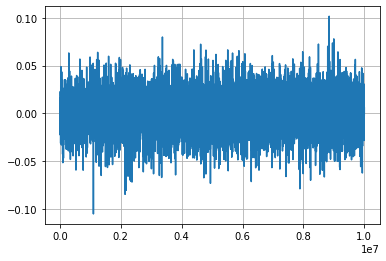

In [19]:
rewards = pd.Series(keep_rewards)
rewards.rolling(500).mean().plot(grid=True)

array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

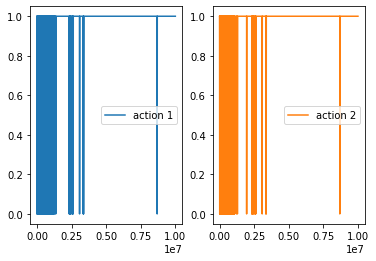

In [20]:
actions_df = pd.DataFrame(keep_actions)
actions_df.columns = ['action 1', 'action 2']
actions_df.plot(subplots=True, layout=(1,2))

<AxesSubplot:>

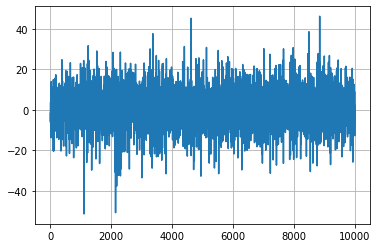

In [21]:
episodic_rewards = pd.Series(keep_episodic_rewards)
episodic_rewards.plot(grid=True)

<AxesSubplot:>

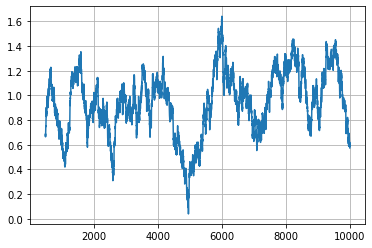

In [22]:
episodic_rewards.rolling(500).mean().plot(grid=True)

In [23]:
actions_series = pd.Series(keep_actions)
tmp = actions_series.value_counts()
tmp[tmp>0]
#tmp[tmp>2]

(1, 1)    9912903
(0, 0)      29526
(1, 0)      28889
(0, 1)      28682
dtype: int64